#Description

In this approach, we first labeled the indices for the different sectors and then partitioned them into training and testing sets (80-20 split). Prior to training the model, we preprocessed the company descriptions to remove any irrelevant information. 

To explore the use of advanced natural language processing techniques, we experimented with a new state-of-the-art sentence transformer that is not yet available in the Hugging Face library. Specifically, we used the 'hkunlp/instructor-large' sentence transformer to embed each company description, along with its corresponding context depending on the nature of the problem. The embedded sentences were then fed into the OneVsRestClassifier.

The OneVsRestClassifier employed the Support Vector Classifier (SVC) model as an estimator with the default radial basis function (rbf) kernel and deafult number of iterations.

We experimented with different contexts to find the best approach.


#Preprocessing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/drive/MyDrive/wrds_data.csv")
data.head()

,Unnamed: 0,conm,gind,gsector,naics,busdesc,spcindcd,GICS_Sector,naics_main,NAICS_Sector
0,2,AAI CORP,NaN,NaN,NaN,"AAI Corporation, together with its subsidiarie...",230.0,NaN,No,NaN
1,3,A.A. IMPORTING CO INC,255040.0,25.0,442110.0,"A.A. Importing Company, Inc. designs, manufact...",449.0,Consumer Discretionary,44,Retail Trade
2,4,AAR CORP,201010.0,20.0,423860.0,AAR Corp. provides products and services to co...,110.0,Industrials,42,Wholesale Trade
3,5,A.B.A. INDUSTRIES INC,NaN,NaN,NaN,A.B.A. Industries Inc. was acquired by McSwain...,110.0,NaN,No,NaN
4,6,ABC INDS INC,NaN,NaN,NaN,"ABC Industries, Inc. manufactures and supplies...",415.0,NaN,No,NaN


In [ ]:
data = data[data.columns[2:]]

In [ ]:
data.dropna(subset=['gind'], how='any', inplace=True)

In [ ]:
data['gind'] = data['gind'].astype(int)

In [ ]:
data.drop(columns = ["spcindcd", "naics_main", "NAICS_Sector", "GICS_Sector", "naics", "gsector"], axis=1, inplace=True)

In [ ]:
gics_sector={10: "Energy", 15: "Materials", 20: "Industrials", 25: "Consumer Discretionary (Consumer Cyclical)", 30: "Consumer Staples (Consumer Defensive)", 35: "Health Care", 40: "Financials", 45: "Information Technology", 50: "Communication Services", 55: "Utilities", 60: "Real Estate"}
gics_industry_group={1010: "Energy", 1510: "Materials", 2010: "Capital Goods", 2020: "Commercial & Professional Services", 2030: "Transportation", 2510: "Automobiles & Components", 2520: "Consumer Durables & Apparel", 2530: "Consumer Services", 2550: "Retailing", 3010: "Food & Staples Retailing", 3020: "Food, Beverage & Tobacco", 3030: "Household & Personal Products", 3510: "Health Care Equipment & Services", 3520: "Pharmaceuticals, Biotechnology  & Life Sciences", 4010: "Banks", 4020: "Diversified Financials", 4030: "Insurance", 4510: "Software & Services", 4520: "Technology Hardware & Equipment", 4530: "Semiconductors & Semiconductor Equipment", 5010: "Telecommunication Services", 5020: "Media & Entertainment", 5510: "Utilities", 6010: "Real Estate"}
gics_industry = {101010: "Energy Equipment & Services", 101020: "Oil, Gas & Consumable Fuels", 151010: "Chemicals", 151020: "Construction Materials", 151030: "Containers & Packaging", 151040: "Metals & Mining", 151050: "Paper & Forest Products", 201010: "Aerospace & Defense", 201020: "Building Products", 201030: "Construction & Engineering", 201040: "Electrical Equipment", 201050: "Industrial Conglomerates", 201060: "Machinery", 201070: "Trading Companies & Distributors", 202010: "Commercial Services & Supplies", 202020: "Professional Services", 203010: "Air Freight & Logistics", 203020: "Airlines", 203030: "Marine", 203040: "Road & Rail", 203050: "Transportation Infrastructure", 251010: "Auto Components", 251020: "Automobiles", 252010: "Household Durables", 252020: "Leisure Products", 252030: "Textiles, Apparel & Luxury Goods", 253010: "Hotels, Restaurants & Leisure", 253020: "Diversified Consumer Services", 255010: "Distributors", 255020: "Internet & Direct Marketing Retail", 255030: "Multiline Retail", 255040: "Specialty Retail", 301010: "Food & Staples Retailing", 302010: "Beverages", 302020: "Food Products", 302030: "Tobacco", 303010: "Household Products", 303020: "Personal Products", 351010: "Health Care Equipment & Supplies", 351020: "Health Care Providers & Services", 351030: "Health Care Technology", 352010: "Biotechnology", 352020: "Pharmaceuticals", 352030: "Life Sciences Tools & Services", 401010: "Banks", 401020: "Thrifts & Mortgage Finance", 402010: "Diversified Financial Services", 402020: "Consumer Finance", 402030: "Capital Markets", 402040: "Mortgage Real Estate Investment Trusts (REITs)", 403010: "Insurance", 451020: "IT Services", 451030: "Software", 452010: "Communications Equipment", 452020: "Technology Hardware, Storage & Peripherals", 452030: "Electronic Equipment, Instruments & Components", 453010: "Semiconductors & Semiconductor Equipment", 501010: "Diversified Telecommunication Services", 501020: "Wireless Telecommunication Services", 502010: "Media", 502020: "Entertainment", 502030: "Interactive Media & Services", 551010: "Electric Utilities", 551020: "Gas Utilities", 551030: "Multi-Utilities", 551040: "Water Utilities", 551050: "Independent Power and Renewable Electricity Producers", 601010: "Equity Real Estate Investment Trusts (REITs)", 601020: "Real Estate Management & Development"}
##############We do not have data for sub industry###############################
gics_sub_industry={10101010: "Oil & Gas Drilling", 10101020: "Oil & Gas Equipment & Services", 10102010: "Integrated Oil & Gas", 10102020: "Oil & Gas Exploration & Production", 10102030: "Oil & Gas Refining & Marketing", 10102040: "Oil & Gas Storage & Transportation", 10102050: "Coal & Consumable Fuels", 15101010: "Commodity Chemicals", 15101020: "Diversified Chemicals", 15101030: "Fertilizers & Agricultural Chemicals", 15101040: "Industrial Gases", 15101050: "Specialty Chemicals", 15102010: "Construction Materials", 15103010: "Metal & Glass Containers", 15103020: "Paper Packaging", 15104010: "Aluminum", 15104020: "Diversified Metals & Mining", 15104025: "Copper", 15104030: "Gold", 15104040: "Precious Metals & Minerals", 15104045: "Silver", 15104050: "Steel", 15105010: "Forest Products", 15105020: "Paper Products", 20101010: "Aerospace & Defense", 20102010: "Building Products", 20103010: "Construction & Engineering", 20104010: "Electrical Components & Equipment", 20104020: "Heavy Electrical Equipment", 20105010: "Industrial Conglomerates", 20106010: "Construction Machinery & Heavy Trucks", 20106015: "Agricultural & Farm Machinery", 20106020: "Industrial Machinery", 20107010: "Trading Companies & Distributors", 20201010: "Commercial Printing", 20201050: "Environmental & Facilities Services", 20201060: "Office Services & Supplies", 20201070: "Diversified Support Services", 20201080: "Security & Alarm Services", 20202010: "Human Resource & Employment Services", 20202020: "Research & Consulting Services", 20301010: "Air Freight & Logistics", 20302010: "Airlines", 20303010: "Marine", 20304010: "Railroads", 20304020: "Trucking", 20305010: "Airport Services", 20305020: "Highways & Railtracks", 20305030: "Marine Ports & Services", 25101010: "Auto Parts & Equipment", 25101020: "Tires & Rubber", 25102010: "Automobile Manufacturers", 25102020: "Motorcycle Manufacturers", 25201010: "Consumer Electronics", 25201020: "Home Furnishings", 25201030: "Homebuilding", 25201040: "Household Appliances", 25201050: "Housewares & Specialties", 25202010: "Leisure Products", 25203010: "Apparel, Accessories & Luxury Goods", 25203020: "Footwear", 25203030: "Textiles", 25301010: "Casinos & Gaming", 25301020: "Hotels, Resorts & Cruise Lines", 25301030: "Leisure Facilities", 25301040: "Restaurants", 25302010: "Education Services", 25302020: "Specialized Consumer Services", 25501010: "Distributors", 25502020: "Internet & Direct Marketing Retail", 25503010: "Department Stores", 25503020: "General Merchandise Stores", 25504010: "Apparel Retail", 25504020: "Computer & Electronics Retail", 25504030: "Home Improvement Retail", 25504040: "Specialty Stores", 25504050: "Automotive Retail", 25504060: "Homefurnishing Retail", 30101010: "Drug Retail", 30101020: "Food Distributors", 30101030: "Food Retail", 30101040: "Hypermarkets & Super Centers", 30201010: "Brewers", 30201020: "Distillers & Vintners", 30201030: "Soft Drinks", 30202010: "Agricultural Products", 30202030: "Packaged Foods & Meats", 30203010: "Tobacco", 30301010: "Household Products", 30302010: "Personal Products", 35101010: "Health Care Equipment", 35101020: "Health Care Supplies", 35102010: "Health Care Distributors", 35102015: "Health Care Services", 35102020: "Health Care Facilities", 35102030: "Managed Health Care", 35103010: "Health Care Technology", 35201010: "Biotechnology", 35202010: "Pharmaceuticals", 35203010: "Life Sciences Tools & Services", 40101010: "Diversified Banks", 40101015: "Regional Banks", 40102010: "Thrifts & Mortgage Finance", 40201020: "Other Diversified Financial Services", 40201030: "Multi-Sector Holdings", 40201040: "Specialized Finance", 40202010: "Consumer Finance", 40203010: "Asset Management & Custody Banks", 40203020: "Investment Banking & Brokerage", 40203030: "Diversified Capital Markets", 40203040: "Financial Exchanges & Data", 40204010: "Mortgage REITs", 40301010: "Insurance Brokers", 40301020: "Life & Health Insurance", 40301030: "Multi-line Insurance", 40301040: "Property & Casualty Insurance", 40301050: "Reinsurance", 45102010: "IT Consulting & Other Services", 45102020: "Data Processing & Outsourced Services", 45102030: "Internet Services & Infrastructure", 45103010: "Application Software", 45103020: "Systems Software", 45201020: "Communications Equipment", 45202030: "Technology Hardware, Storage & Peripherals", 45203010: "Electronic Equipment & Instruments", 45203015: "Electronic Components", 45203020: "Electronic Manufacturing Services", 45203030: "Technology Distributors", 45301010: "Semiconductor Equipment", 45301020: "Semiconductors", 50101010: "Alternative Carriers", 50101020: "Integrated Telecommunication Services", 50102010: "Wireless Telecommunication Services", 50201010: "Advertising", 50201020: "Broadcasting", 50201030: "Cable & Satellite", 50201040: "Publishing", 50202010: "Movies & Entertainment", 50202020: "Interactive Home Entertainment", 50203010: "Interactive Media & Services", 55101010: "Electric Utilities", 55102010: "Gas Utilities", 55103010: "Multi-Utilities", 55104010: "Water Utilities", 55105010: "Independent Power Producers & Energy Traders", 55105020: "Renewable Electricity", 60101010: "Diversified REITs", 60101020: "Industrial REITs", 60101030: "Hotel & Resort REITs", 60101040: "Office REITs", 60101050: "Health Care REITs", 60101060: "Residential REITs", 60101070: "Retail REITs", 60101080: "Specialized REITs", 60102010: "Diversified Real Estate Activities", 60102020: "Real Estate Operating Companies", 60102030: "Real Estate Development", 60102040: "Real Estate Services"}

In [ ]:
import math

temp = []
for item in data["gind"]:
  temp.append(math.floor(item/10000))

data["gind"] = temp

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["gind"] = encoder.fit_transform(data["gind"])
data["gind"].value_counts()

6     5363
7     5192
3     4662
5     4565
2     3934
1     3833
0     2822
4     1433
8     1285
9      740
10     509
Name: gind, dtype: int64

In [ ]:
data.head()

,gind,busdesc
1,3,"A.A. Importing Company, Inc. designs, manufact..."
2,2,AAR Corp. provides products and services to co...
5,3,"ABKCO Music & Records, Inc. operates as an ent..."
6,1,"Makes cold and warm forgings, including transm..."
7,2,ACF Industries LLC operates as a machinery (co...


In [ ]:
my_tags = list(gics_sector.values())
len(my_tags)

11

#Using the sentence transformer

In [ ]:
!pip install --upgrade git+https://github.com/UKPLab/sentence-transformers.git
!pip install --upgrade git+https://github.com/Muennighoff/sentence-transformers.git@sgpt_poolings_specb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UKPLab/sentence-transformers.git to /tmp/pip-req-build-znhfkud5
  Running command git clone --filter=blob:none --quiet https://github.com/UKPLab/sentence-transformers.git /tmp/pip-req-build-znhfkud5
  Resolved https://github.com/UKPLab/sentence-transformers.git to commit 3e1929fddef16df94f8bc6e3b10598a98f46e62d
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126134 sha256=52634e08a8d99d1a77c1349fc812fa29e4507e418bfb728d5cb7af95e1fefc7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-6x05wh5t/wheels/cc/10/c9/78ca6a3dcf621c1cc1095eabe471d84b1bcd1cf84cc39f5962
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.1
    Uninstalling sentence-transformers-2.2.1:
      Successfull

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Muennighoff/sentence-transformers.git (to revision sgpt_poolings_specb) to /tmp/pip-req-build-ci2f_vlu
  Running command git clone --filter=blob:none --quiet https://github.com/Muennighoff/sentence-transformers.git /tmp/pip-req-build-ci2f_vlu
  Running command git checkout -b sgpt_poolings_specb --track origin/sgpt_poolings_specb
  Switched to a new branch 'sgpt_poolings_specb'
  Branch 'sgpt_poolings_specb' set up to track remote branch 'sgpt_poolings_specb' from 'origin'.
  Resolved https://github.com/Muennighoff/sentence-transformers.git to commit 5c025b34ea665a98cbac028e45d1cea91dc33b86
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.1-py3-none-any.whl size=125738 sha256=1493ce2d1ab0a40b22d52e8f5e73f4c04c4107431eef802ede0e71bf3bac3df0
  Stored in directory: /tmp/pip-ephem-wheel-cache-yg

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("hkunlp/instructor-large")

/usr/local/lib/python3.9/dist-packages/huggingface_hub/file_download.py:637: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


Using Maximum Sequence Length:  512


In [ ]:
Y = list(data["gind"])

#Giving context and embedding

In [ ]:
X = []

for item in list(data["busdesc"]):
  # X.append(["Represent the Business sentence: ", item])
  # X.append(["Represent the Business sentence for classification: ", item])
  # X.append(["Represent the Company Description sentence for classification: ", item])
  X.append(["Represent the Company sentence for classification: ", item])

In [ ]:
X_embed = model.encode(X)

#Train and test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_embed,  Y, test_size=0.2, random_state=0)

#Training the model and predictions

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC())

clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

#Results from predictions

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=my_tags))
print("F1 score is: "+ (str)(f1_score(Y_test, y_pred, average='micro')))

[[462  38  20   3   3   3   5   6   0   5   0]
 [ 18 679  35  18  13  13   8   8   0   1   0]
 [ 24  44 435  71   9  29  21 116   5  15   0]
 [  6  19  60 699  35  21  27  69  19   3   2]
 [  2   6   3  24 192  26   5   1   0   1   0]
 [  3   5   5  10   8 819   8  17   2   1   0]
 [  6   6  12  24   0  20 971  14   0   1   4]
 [  8   8  43  42   3  31  25 924  20   1   1]
 [  0   2   6  49   0  11   2  57 107   2   0]
 [ 21   1  13   0   2   0   3   0   0 110   0]
 [  1   2   5   9   1   6  50   5   1   0  33]]
                                            precision    recall  f1-score   support

                                    Energy       0.84      0.85      0.84       545
                                 Materials       0.84      0.86      0.85       793
                               Industrials       0.68      0.57      0.62       769
Consumer Discretionary (Consumer Cyclical)       0.74      0.73      0.73       960
     Consumer Staples (Consumer Defensive)       0.72      0.

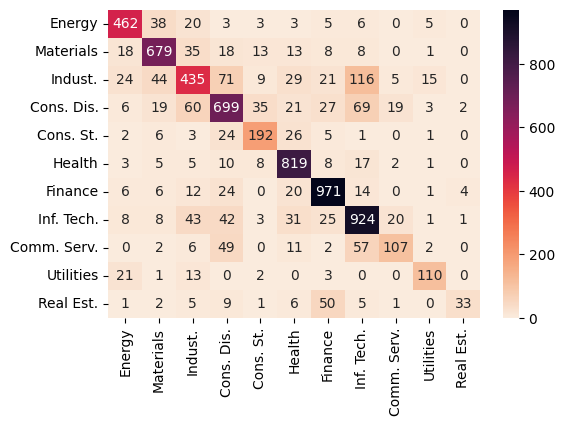